In [ ]:
import os
import cv2
import shutil
import numpy as np

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CanDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        """
        Args:
            root_dir (str): Directory with all the images (can be train or test).
            transform (callable, optional): Optional transform to be applied on a sample.
            is_test (bool, optional): Whether the dataset is for test set (no labels).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test  # Flag to indicate if it's the test dataset
        self.image_paths = []
        self.labels = []
        self.classes = os.listdir(root_dir)
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, file_name))
                    if not self.is_test:
                        self.labels.append(label)  # Add label only for training set
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image  # Return only the image for the test set
        else:
            label = self.labels[idx]  # Return image and label for training set
            return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Crea il dataset di train e test
train_dataset = CanDataset(root_dir='archive/train', transform=transform, is_test=False)
test_dataset = CanDataset(root_dir='archive/test', transform=transform, is_test=True)

# Crea i dataloader per il dataset di train e test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Stampa alcune informazioni sui dataset
print(f"Numero di immagini nel dataset di train: {len(train_dataset)}")
print(f"Numero di immagini nel dataset di test: {len(test_dataset)}\n")
print(f"Classi nel dataset di train: {train_dataset.classes}")
print(f"Classi nel dataset di test: {test_dataset.classes}")

Numero di immagini nel dataset di train: 1478
Numero di immagini nel dataset di test: 620

Classi nel dataset di train: ['ultra red', 'Original green', 'ultra strawberry dreams', 'nitro super dry', 'ultra rosa', 'Aussie Lemonade', 'ultra sunrise', 'ultra gold', 'Pacific Punch', 'ultra watermelon', 'lo carb', 'Mango Loco', 'java salted caramel', 'ultra violet', 'nitro cosmic peach', 'tea lemonade', 'ultra peachy keen', 'ultra black', 'ultra blue']
Classi nel dataset di test: ['ultra red', 'Original green', 'ultra strawberry dreams', 'nitro super dry', 'ultra rosa', 'Aussie Lemonade', 'ultra sunrise', 'ultra gold', 'Pacific Punch', 'ultra watermelon', 'lo carb', 'Mango Loco', 'java salted caramel', 'ultra violet', 'nitro cosmic peach', 'tea lemonade', 'ultra peachy keen', 'ultra black', 'ultra blue']


In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import torch
import torch.nn as nn

# Definisci il dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello pre-addestrato ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modifica l'ultimo layer per adattarlo al numero di classi del dataset
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

# Sposta il modello sul dispositivo
model = model.to(device)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Funzione per addestrare il modello
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Azzerare i gradienti
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass e ottimizzazione
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Addestra il modello
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

/Users/martinapanini/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Loss: 1.3540572841116723
Epoch 2/10, Loss: 0.6581687356563325
Epoch 3/10, Loss: 0.6261652197609556


/Users/martinapanini/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.2823, Test Accuracy: 0.91%


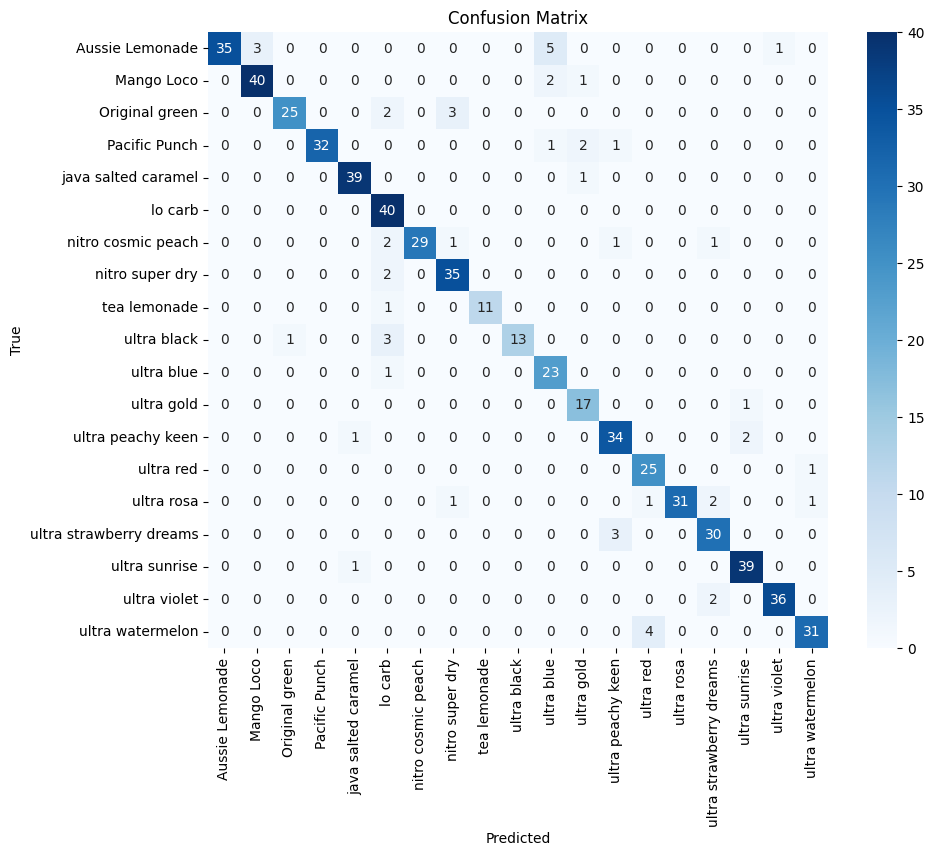

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

def evaluate_model_with_confusion_matrix(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model and print confusion matrix
evaluate_model_with_confusion_matrix(model, test_loader, criterion)

In [ ]:
# Define the model class
class FinalModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FinalModel, self).__init__()
        self.base_model = base_model
        self.base_model.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Ensure pooling to (batch_size, 2048)
        self.base_model.fc = nn.Linear(2048, num_classes)  # Update to match feature size
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1)  # Edge segmentation output
        )
    
    def forward(self, x):
        features = self.base_model(x)  # Extract features from the base model
        classification_output = self.base_model.fc(features)  # Classify based on features
        segmentation_output = self.segmentation_head(features)  # Segment based on features
        return classification_output, segmentation_output

# Use the updated way to load pretrained models (weights instead of pretrained)
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Example, change weights if needed
num_classes = 10  # Update this based on your dataset classes
final_model = FinalModel(base_model, num_classes)
final_model = final_model.to(device)  # Move the model to the selected device

# Function for extracting intermediate features and performing classification and segmentation
def classify_and_segment(model, dataloader):
    model.eval()  # Ensure model is in evaluation mode
    color_predictions = []
    edge_segmentations = []
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            features = model.base_model(images)  # Get features from the base model
            features = torch.flatten(features, start_dim=1)  # Flatten to (batch_size, 2048)
            color_preds = model.base_model.fc(features)  # Classify based on flattened features
            edge_segs = model.segmentation_head(features)  # Segment based on flattened features
            
            color_predictions.append(color_preds.cpu())  # Move to CPU for further processing
            edge_segmentations.append(edge_segs.cpu())  # Move to CPU for further processing
    
    return color_predictions, edge_segmentations

# Perform classification and segmentation
color_predictions, edge_segmentations = classify_and_segment(final_model, dataloader)

# Print the results
print("Color Predictions:", color_predictions)
print("Edge Segmentations:", edge_segmentations)